# Coursework

## Getting the data

The first thing that needs to be done is get the data from the .csv file and converting it to our variables X and y that are going to be used to train and test our models.

In [2]:
#read the file and separate data into X and Y
import pandas
import numpy as np
import matplotlib.pyplot as plt
filename = "coursework_other.csv"
names = ["Date", "Rented Bike Count", "Hour", "Temperature", "Humidity", "Wind speed",
         "Visibility", "Dew point temperature", "Solar Radiation",
         "Rainfall", "Snowfall", "Seasons", "Holiday", "Functioning Day"]
data = pandas.read_csv(filename, names=names, encoding= "unicode_escape")

In [3]:
# X is data so it has to be everything except for the target
X = data.loc[:][1:].to_numpy()
y = data.loc[:]["Rented Bike Count"].to_numpy()[1:]

X = np.delete(X,1,1)

print(f"{len(X)}, {len(y)}")

8760, 8760


In [4]:
#function to help map the seasons to numbers
def find(array, string):
    for i in range(len(array)):
        if (array[i] == string):
            return i
    return -1

## Manipulating data

Now that we have the data divided into X and y we need to manipulate it so that it is ready for our models. Our data has strings in it, we need to find a way to map those strings to number form so that the models can make predictions on them.

In [5]:
#easier for me to work with a list
Xtemp = X.tolist()

#lists for mapping the seasons strings to numbers
seasons = []
seasonValue = []
value = 0

for i in range(len(X)):
    #separate the date into variables
    date = X[i][0]
    day = int(date[:2])
    month = int(date[3:5])
    year = int(date[6:10])
    
    #map string seasons to numbers
    index = find(seasons, Xtemp[i][11])
    if (index == -1):
        seasons.append(Xtemp[i][11])
        seasonValue.append(value)
        Xtemp[i][10] = value
        value += 1
    else:
        Xtemp[i][10] = seasonValue[index]
    
    #map holiday or no holiday to number
    if (Xtemp[i][11] == "Holiday"):
        Xtemp[i][11] = 1
    else:
        Xtemp[i][11] = 0
    
    #map yes or no to numbers
    if (Xtemp[i][12] == "Yes"):
        Xtemp[i][12] = 1
    else:
        Xtemp[i][12] = 0
    
    #insert the date number by number at the start
    Xtemp[i].pop(0)
    Xtemp[i].insert(0, year)
    Xtemp[i].insert(0, month)
    Xtemp[i].insert(0, day)

Xtemp = np.array(Xtemp).astype(float)
X = Xtemp
#This is how the strings were mapped:
#Winter = 0, Spring = 1, Summer = 2, Autumn = 3 [0, 1, 2, 3]
#Holiday = 1, No holiday = 0
#Yes = 1, No = 0

## Visualizing Data

Now that we have changed our data to a model friendly form, we need to see how the data is distributed to select the best model to fit it. All data will be plotted against the target.

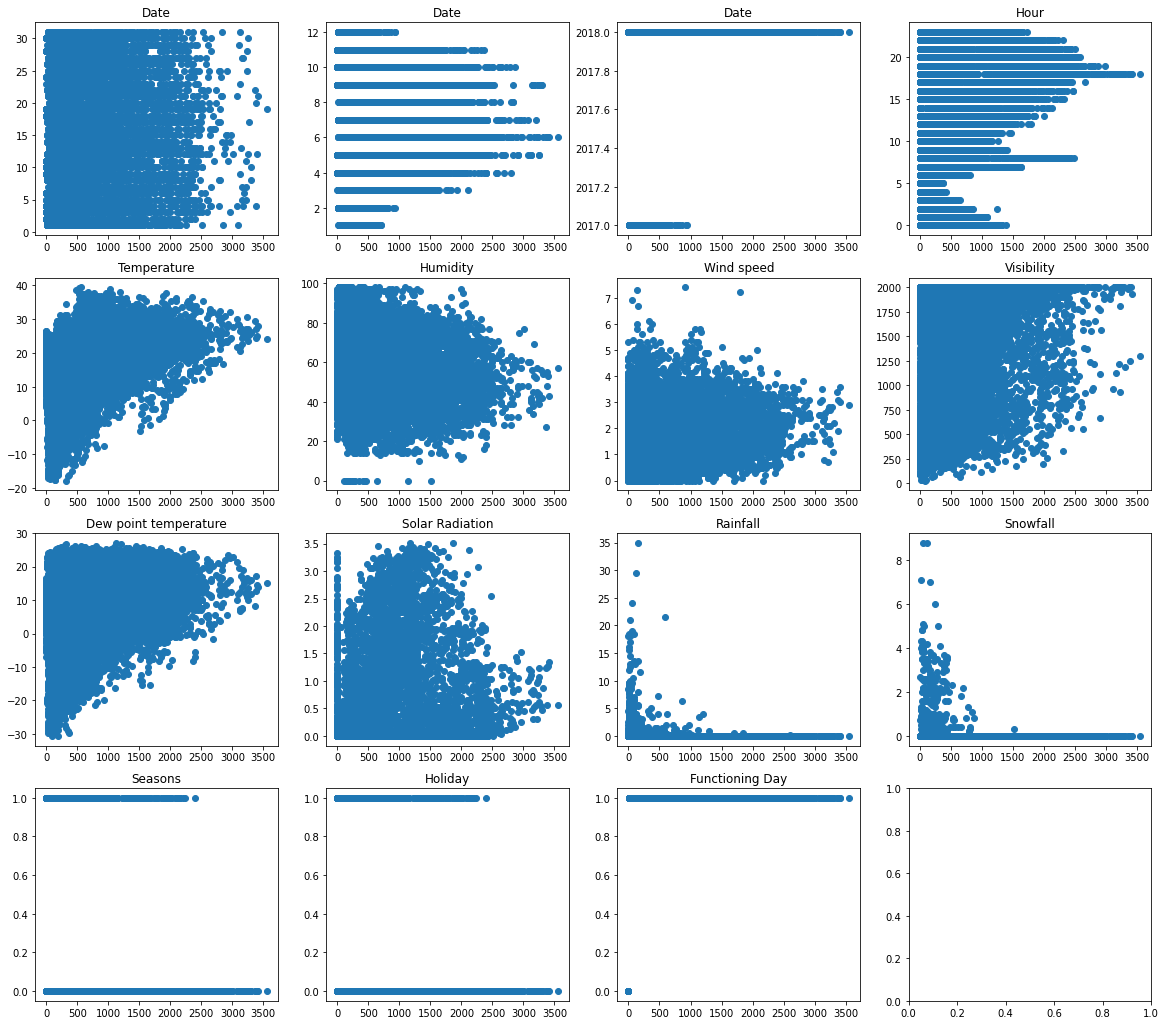

In [6]:
#import seaborn as sns
#x = pandas.DataFrame(Xtemp)
#sns.pairplot(x, x_vars=[3], height=8)

figure, axis = plt.subplots(4, 4, figsize=(20,18))

k = 0

for i in range(4):
    for j in range(4):
        axis[i,j].scatter(y.astype(int), Xtemp[:,k])
        if (k < 3):
            axis[i,j].set_title("Date")
        else:
            axis[i,j].set_title(names[k-1])
        k+=1
        if k == 15:
            break
plt.show()
figure.savefig('visualization.jpg', dpi = 300)

## Model Selection

Now that we have seen the data, we can go on to select a model and figuring out the best hyperparameters for our problem (if there are any).

### Split data

The first step is to split our data into training and test sets.

In [7]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, y, test_size = 0.2, random_state = 10)
#since y is still in string form, we need to change it to float
Ytrain = Ytrain.astype(float)
Ytest = Ytest.astype(float)

### Selecting the Hyperparameters

  On the below code, you can see how the hyperparameters are selected. We run the model through all the possible algorithms, weights and values of k. At the end, a text is printed to know which values for the hyperparameters minimized the mean absolute error, which means, the hyperparameters that made the smallest error when predicting unseen data.

In [8]:
from sklearn.metrics import mean_absolute_error, r2_score

Min value: 172.0643340217979
Obtained with: best | friedman_mse,
Depth: 12


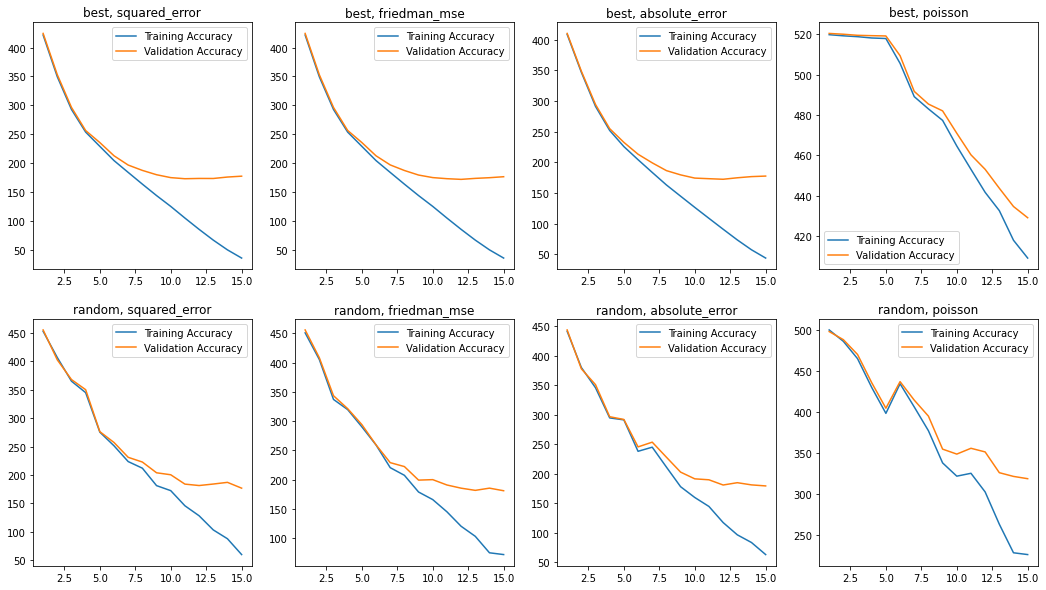

In [9]:
#Adapted from Worksheet 2
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeRegressor

cv = KFold(n_splits=5,random_state=10, shuffle=True)

#The max depth
max_d = 15

figure, axis = plt.subplots(2, 4, figsize=(18,10))

trainaccuracy = [[] for _ in range(max_d)]
valaccuracy = [[] for _ in range(max_d)]

criterions = ["squared_error", "friedman_mse", "absolute_error", "poisson"]
splitters = ["best", "random"]

minValue = [1000, 0, ' ', ' ']

i = 0
for criterion in criterions:
    j = 0
    for splitter in splitters: 
        for depth in range(max_d):
            #instantiate the tree with the hyperparameters
            tree = DecisionTreeRegressor(criterion=criterion,splitter=splitter,max_depth=depth+1)

            for train_index, val_index in cv.split(Xtrain):
                Xtr, Xval, Ytr, Yval = Xtrain[train_index],\
                    Xtrain[val_index], Ytrain[train_index], Ytrain[val_index]
                #fit the data
                model=tree.fit(Xtr, Ytr)
                #make predictions
                Ypredtrain=model.predict(Xtr)
                Ypredval=model.predict(Xval)
                #save the results
                trainaccuracy[depth].append(mean_absolute_error(Ytr,Ypredtrain))
                valaccuracy[depth].append(mean_absolute_error(Yval,Ypredval))

        mean_train_acc = np.mean(trainaccuracy, axis=1)
        mean_val_acc = np.mean(valaccuracy, axis=1)

        trainaccuracy = [[] for _ in range(max_d)]
        valaccuracy = [[] for _ in range(max_d)]
        
        #check if we have a smaller value for the MAE
        if minValue[0] > np.amin(mean_val_acc):
            minValue[0] = np.amin(mean_val_acc)
            minValue[1] = np.argmin(mean_val_acc)+1
            minValue[2] = splitter
            minValue[3] = criterion

        x = range(1, max_d+1)
        axis[j,i].plot(x, mean_train_acc, label='Training Accuracy')
        axis[j,i].plot(x, mean_val_acc, label='Validation Accuracy')
        axis[j,i].legend()
        axis[j,i].set_title(f"{splitter}, {criterion}")
        j+=1
    i+=1
print(f"Min value: {minValue[0]}\nObtained with: {minValue[2]} | {minValue[3]},\nDepth: {minValue[1]}")
plt.show()

Text(0, 0.5, 'R2')

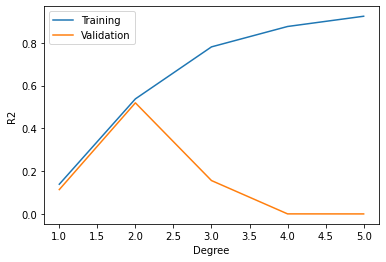

In [10]:
#adapted from worksheet 2
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

lr = LinearRegression()

Xtr, Xval, Ytr, Yval = train_test_split(Xtrain, Ytrain, test_size=0.2, random_state=0)
r2_tr = []
r2_val = []
max_deg = 5
for i in range(max_deg):
    poly=PolynomialFeatures(degree=i+1)
    Xtrain_new = poly.fit_transform(Xtr) 
    Xval_new = poly.fit_transform(Xval)
    lr.fit(Xtrain_new, Ytr)
    pred_tr = lr.predict(Xtrain_new)
    pred_v = lr.predict(Xval_new)
    r2_tr.append(r2_score(pred_tr, Ytr))
    r2_val.append(r2_score(pred_v, Yval))

plt.plot(range(1, max_deg+1), r2_tr, label='Training')
plt.plot(range(1, max_deg+1), r2_val, label='Validation')
plt.legend()
plt.xlabel('Degree')
plt.ylabel('R2')

## Training and Testing

Now that we know which hyperparameters to take, the next step is to train the models with the hyperparameters chosen and predict on the test data

In [11]:
from sklearn.dummy import DummyRegressor

dummy = DummyRegressor(strategy='median')
modelTrainD = dummy.fit(Xtrain, Ytrain)
YpredTrainD = modelTrainD.predict(Xtrain) 
YpredTestD = modelTrainD.predict(Xtest)

In [12]:
from sklearn.tree import DecisionTreeRegressor

dt = DecisionTreeRegressor(criterion='friedman_mse', splitter='best', max_depth=12)
model=dt.fit(Xtrain, Ytrain)
YpredTestDt=model.predict(Xtest)

In [13]:
poly=PolynomialFeatures(2)
Xtrain_new = poly.fit_transform(Xtrain)
Xtest_new = poly.fit_transform(Xtest)
lr.fit(Xtrain_new, Ytrain)
YpredTestPL = lr.predict(Xtest_new)

## Results

Now that each model has been trained and tested, we can now evaluate how our models adapted to the data and if it was successfull predicting it.

In [14]:
print("\tDummy\tPolinomial\tTree")
print("MAE", end='\t')
print(format(mean_absolute_error(Ytest, YpredTestD), ".3f"), end='\t')
print(format(mean_absolute_error(Ytest, YpredTestPL), ".3f"), end='\t\t')
print(format(mean_absolute_error(Ytest, YpredTestDt), ".3f"))
print("R2", end='\t')
print(format(r2_score(Ytest, YpredTestD), ".3f"), end='\t')
print(format(r2_score(Ytest, YpredTestPL), ".3f"), end='\t\t')
print(format(r2_score(Ytest, YpredTestDt), ".3f"))

	Dummy	Polinomial	Tree
MAE	496.136	260.957		156.265
R2	-0.060	0.678		0.810


### Polynomial Regression

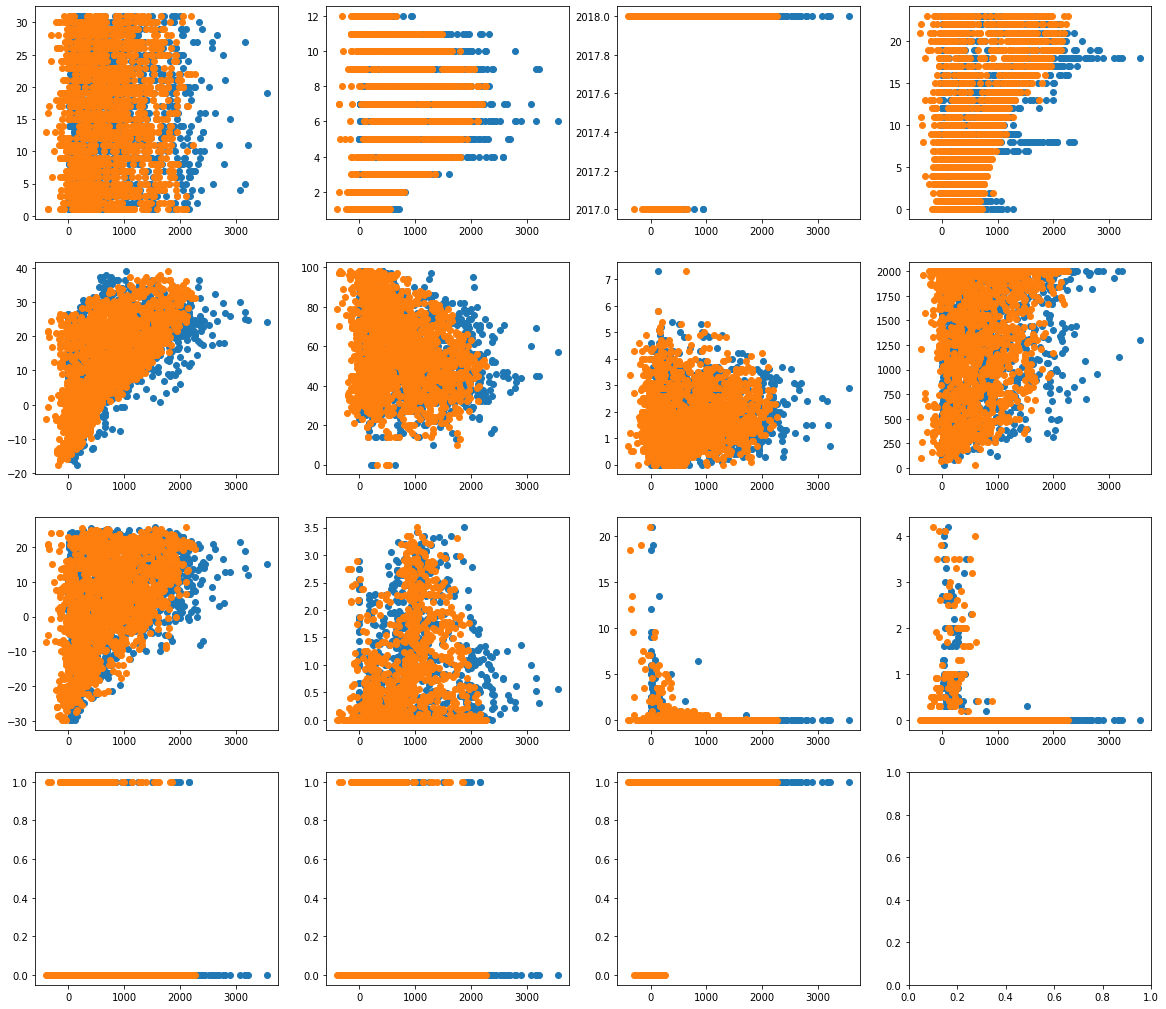

In [15]:
figure, axis = plt.subplots(4, 4, figsize=(20,18))
k = 0
for i in range(4):
    for j in range(4):
        axis[i,j].scatter(Ytest, Xtest[:,k])
        axis[i,j].scatter(YpredTestPL, Xtest[:,k])
        k+=1
        if k == 15:
            break

### Decision tree regressor

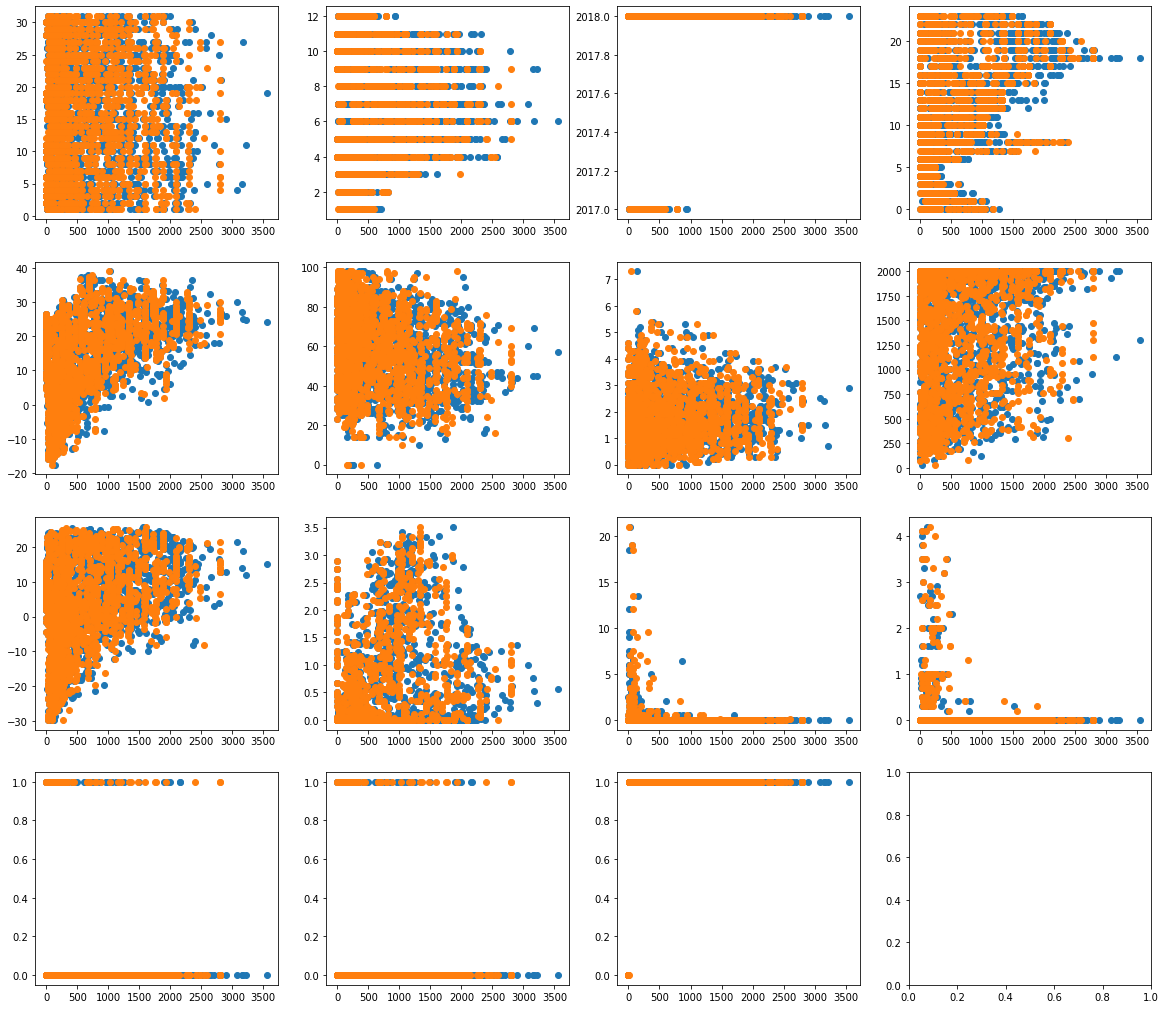

In [16]:
figure, axis = plt.subplots(4, 4, figsize=(20,18))
k = 0
for i in range(4):
    for j in range(4):
        axis[i,j].scatter(Ytest, Xtest[:,k])
        axis[i,j].scatter(YpredTestDt, Xtest[:,k])
        k+=1
        if k == 15:
            break